In [1]:
import stokespy
from stokespy.instload import load_HinodeSP_stokes, load_HinodeSP_magvec, load_HMI_stokes, load_HMI_magvec 
from stokespy import StokesParamCube, StokesParamMap, StokesProfile
import datetime
import astropy
import astropy.units as u
from astropy.coordinates import SkyCoord, SpectralCoord

from sunpy.image import coalignment
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os

from scipy import ndimage

import warnings
warnings.filterwarnings('ignore')

# Setup the autoreload function.
%load_ext autoreload
%autoreload 2

# Load SDO/HMI data series

SDO/HMI data can be accessed through a number of repositories.\ 
We make use of the sunpy.net.Fido API to retrieve data JSOC.

The user needs to imput a date (currently as an astropy.time.Time object) or a string
that can be converted into and astropy.time.Time object.

The top level data directory can be supplied by the user.
By setting the download=True keyword the relevant level1 and level2 data is searched and retrived from JSOC.

Setting the keyword derotate=True applies a rotation to the data to aling the observations with the SDO axis for Solar N

In [69]:
user_date = astropy.time.Time(datetime.datetime(2017, 9, 5, 3, 4, 4), scale='tai')  
user_dir = os.getcwd() + '/Data/SDO/'

if not os.path.exists(user_dir):
    print('Data directory created: ', user_dir)
    os.makedirs(user_dir)

user_email = 'gdima@hawaii.edu'
lvl1_c_HMI = load_HMI_stokes(user_dir, user_date, user_email=user_email, 
                 download=False, show_files=False, derotate=True)
print(' ~~~~~~ ')
lvl2_c_HMI = load_HMI_magvec(user_dir, user_date, user_email=user_email, 
                 download=False, show_files=False, derotate=True)

Time window used for the search:  <sunpy.net.attrs.Time(2017-09-05 03:04:03.000, 2017-09-05 03:04:05.000)>
User data directory: /Users/gdima/Desktop/stokespy/stokespy_notebooks/Data/SDO/
No download requested.
Loaded 24 Stokes files with unique timestamp(s):
['20170905_030000_TAI']
OBS: Derotating each image
Created Stokes data cube with dimensions: (4, 6, 4098, 4098)
 ~~~~~~ 
Time window used for the search:  <sunpy.net.attrs.Time(2017-09-05 03:04:03.000, 2017-09-05 03:04:05.000)>
User data directory: /Users/gdima/Desktop/stokespy/stokespy_notebooks/Data/SDO/
No download requested.
Loaded 25 inversion files with timestamps: 
['20170905_030000_TAI']
OBS: Derotating each magnetic field image.
Created magnetic field data cube with dimensions: (3, 4098, 4098)


We can look at information contained in the World Coordinate System (WCS)
associated with each cube.\
Note the ordering of indices for arrays in Python is (row, column) which is reversed compared to the information in the WCS.

In [62]:
lvl1_c_HMI.wcs,lvl2_c_HMI.wcs

(WCS Keywords
 
 Number of WCS axes: 4
 CTYPE : 'HPLN-TAN'  'HPLT-TAN'  'WAVE'  'STOKES'  
 CRVAL : 0.0  0.0  6.173345e-07  0.0  
 CRPIX : 2057.7563593149  2047.3749883579  3.5  0.0  
 PC1_1 PC1_2 PC1_3 PC1_4  : 1.0  7.4040177438477e-22  0.0  0.0  
 PC2_1 PC2_2 PC2_3 PC2_4  : 7.4040177438477e-22  1.0  0.0  0.0  
 PC3_1 PC3_2 PC3_3 PC3_4  : 0.0  0.0  1.0  0.0  
 PC4_1 PC4_2 PC4_3 PC4_4  : 0.0  0.0  0.0  1.0  
 CDELT : 0.00014009532001283  0.00014009532001283  6.88e-12  1.0  
 NAXIS : 0  0,
 WCS Keywords
 
 Number of WCS axes: 3
 CTYPE : 'HPLN-TAN'  'HPLT-TAN'  'Parameter'  
 CRVAL : 0.0  0.0  0.0  
 CRPIX : 2057.7563593149  2047.3749883579  0.0  
 PC1_1 PC1_2 PC1_3  : 1.0  7.4040177438477e-22  0.0  
 PC2_1 PC2_2 PC2_3  : 7.4040177438477e-22  1.0  0.0  
 PC3_1 PC3_2 PC3_3  : 0.0  0.0  1.0  
 CDELT : 0.00014009532001283  0.00014009532001283  1.0  
 NAXIS : 0  0)

The StokesCube objects contain custom plotting functionality to display all the data using
the WCS information.\
A default call to the plot() method will display all the data in an interactive way using a simple slider to scroll through the available wavelegths.

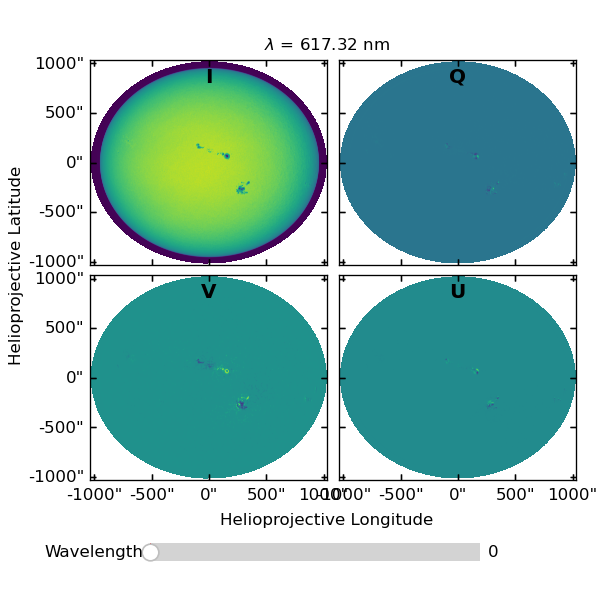

In [64]:
%matplotlib widget

lvl1_c_HMI.plot()

Alternatively we can plot only part of the data using the built-in slicing enabled through NDCube.\

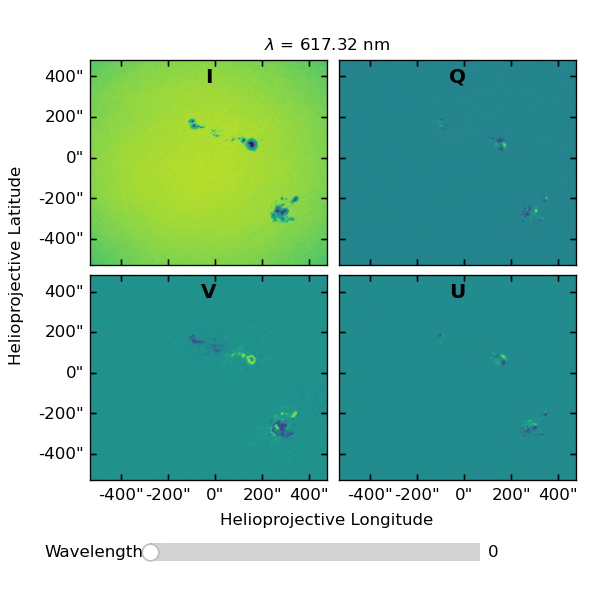

In [65]:
%matplotlib widget

lvl1_c_HMI[:,:,1000:3000,1000:3000].plot()

The MagVectorCube object holds the associated inverted magnetic field parameters.
Currently the plotting functionality is attached to specific properties like the total magnetic field strength B, the inclination and azimuth.

We plan to expand the functionality of this object in the future by adding new quantities like the projected magnetic field strength. 

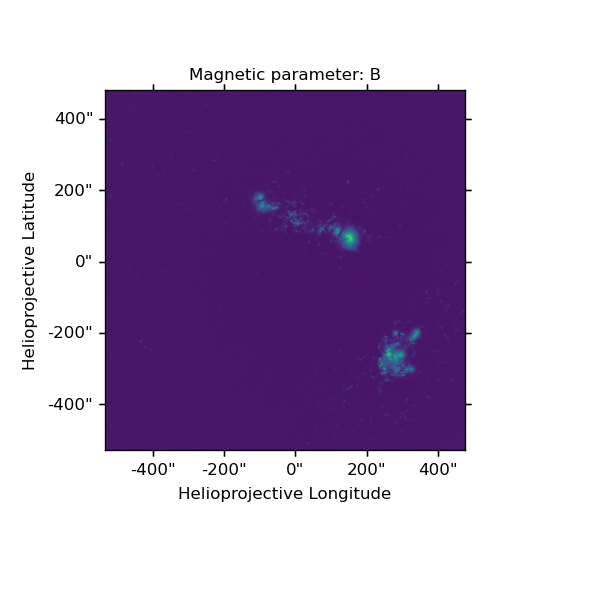

In [67]:
%matplotlib widget

lvl2_c_HMI.B[1000:3000,1000:3000].plot()

# Load Hinode/SP data series

Currently Hinode/SP data must be obtained manually from the following website:
https://csac.hao.ucar.edu/sp_data.php

Enter the desired date range in the GUI.\
In this example we used: \
Start = 2017.9.5 00:00\
End = 2017.9.5 06:00

A new window will appear with a list of observations and
for this example we selected the active region observation at
"2017-09-05 03:04:04".

We only need to download level1 and level2 data.\
A fuller description of the data products can be found here:
https://www2.hao.ucar.edu/csac/csac-data/sp-data-description

Once the selections are made you will be prompted for an email address so you can be notified when the data has been packaged into a zip file for download.

You should fairly quickly (<1 min) receive an email notification with a link that starts the download of the zip file. 

For this example we assume that files are stored using the default directory structure:\
[user_dir]/level1/YYYY/MM/DD/SP3D/[user_date]/\
[user_dir]/level2/YYYY/MM/DD/SP3D/[user_date]/\

The user_date is a unique identifier for each dataset.

In [71]:
user_date = '20170905_030404'

# Point to the top level directory under which level1 and level2 data are stored.
user_dir = os.getcwd() + '/Data/Hinode/'
lvl1_c_SP = load_HinodeSP_stokes(user_dir, user_date)

# The level2 data includes a list of parameters. 
# >>> Find a reference to all the parameters? 
magnetic_params=['Field_Strength', 
                 'Field_Inclination', 
                 'Field_Azimuth',
                 'Stray_Light_Fill_Factor']
lvl2_c_SP = load_HinodeSP_magvec(user_dir, user_date, magnetic_params=magnetic_params)


Loading data from:  /Users/gdima/Desktop/stokespy/stokespy_notebooks/Data/Hinode/level1/2017/09/05/SP3D/20170905_030404
Created Stokes data cube with dimensions: (4, 112, 512, 485)
Loading data from:  /Users/gdima/Desktop/stokespy/stokespy_notebooks/Data/Hinode/level2/2017/09/05/SP3D/20170905_030404
Created magnetic field data cube with dimensions: (4, 512, 485)


We can look at information contained in the World Coordinate System (WCS)
associated with each cube.\
Note the ordering of indices for arrays in Python is (row, column) which is reversed compared to the information in the WCS.

In [72]:
lvl1_c_SP.wcs, lvl2_c_SP.wcs

(WCS Keywords
 
 Number of WCS axes: 4
 CTYPE : 'HPLN-TAN'  'HPLT-TAN'  'WAVE'  'STOKES'  
 CRVAL : 0.03610083333333333  0.011277222222222221  6.30208e-07  0.0  
 CRPIX : 243.0  256.5  56.5  0.0  
 PC1_1 PC1_2 PC1_3 PC1_4  : 1.0  0.0  0.0  0.0  
 PC2_1 PC2_2 PC2_3 PC2_4  : 0.0  1.0  0.0  0.0  
 PC3_1 PC3_2 PC3_3 PC3_4  : 0.0  0.0  1.0  0.0  
 PC4_1 PC4_2 PC4_3 PC4_4  : 0.0  0.0  0.0  1.0  
 CDELT : 8.253888951416667e-05  8.888333208027778e-05  2.1549e-12  1.0  
 NAXIS : 0  0,
 WCS Keywords
 
 Number of WCS axes: 3
 CTYPE : 'HPLN-TAN'  'HPLT-TAN'  'Parameter'  
 CRVAL : 0.03610083262125651  0.01127722226928711  0.0  
 CRPIX : 243.0  256.5  0.0  
 PC1_1 PC1_2 PC1_3  : 1.0  0.0  0.0  
 PC2_1 PC2_2 PC2_3  : 0.0  1.0  0.0  
 PC3_1 PC3_2 PC3_3  : 0.0  0.0  1.0  
 CDELT : 8.253888888888889e-05  8.888277777777778e-05  1.0  
 NAXIS : 0  0)

Other aspects of the data cube are stored as convenience methods. \
For example we can look at the wavelength axis (or part of it) by calling spectral_axis or the units for each axis by calling world_axis_units

In [75]:
print(lvl1_c_SP.spectral_axis.to(u.nm)[0:20])
print('Units for each axis: ', lvl1_c_SP.wcs.world_axis_units)

[630.08840305 630.09055795 630.09271285 630.09486775 630.09702265
 630.09917755 630.10133245 630.10348735 630.10564225 630.10779715
 630.10995205 630.11210695 630.11426185 630.11641675 630.11857165
 630.12072655 630.12288145 630.12503635 630.12719125 630.12934615] nm
Units for each axis:  ['deg', 'deg', 'm', '']


Before we proceed we can check the data was loaded correctly.

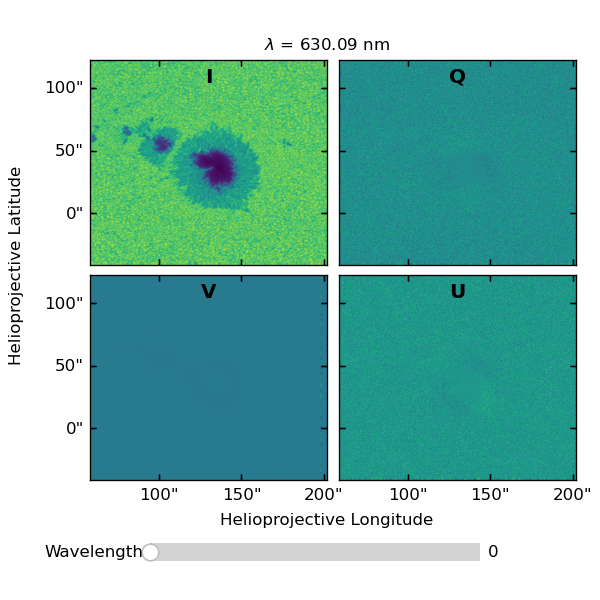

In [77]:
%matplotlib widget

lvl1_c_SP.plot()

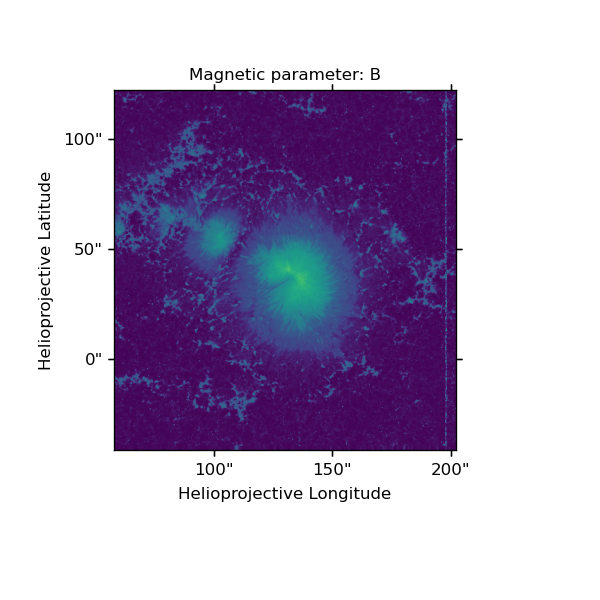

In [78]:
lvl2_c_SP.B.plot()

# Co-align Hinode and HMI observations

One application of the stokespy package involves comparing measurements from the same region,
perhaps indicated by a set of world coordinates. However, because the WCS attached to each datacube 
is only as good as the information in the data headers. 

Thanks to good temporal coverage from HMI we can always find co-temporal observations from HMI and Hinode/SP. We first look at the alignment between features in the two images naively assuming the WCS information is correct. We notice large differences between the coordinates assigned to the same AR feature on the sun. 

Using a cross-correlation technique we can find the misalignment due to translation between the two data sets. 
This particular example does not account for misalignment involving rotations but a more involved version of this example could be created to account for rotations as well. However, it would involve resampling of the data. 

## Load images to compare

<<< Hinode map >>>\
We can select the wavelength near 603.19 nm for the continuum.

Here we use stokespy.StokesParamMap which is a custom class similar to StokesCube for 2D data slices.
Convenience methods with are provided for the StokesCube object to select a 2D image given an input unit quantity.  

In [79]:
wav_SP = 630.19 * u.nm

SP_map = lvl1_c_SP.I_map(wav_SP)
print(type(SP_map))
print(SP_map)

ix_0, wav0 =  47 6.3018968335e-07 m
<class 'stokespy.stokespy.StokesParamMap'>
NDCube
------
Dimensions: [512. 485.] pix
Physical Types of Axes: [('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat'), ('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat')]
Unit: None
Data Type: float64


<<< HMI map >>> \
We can also pass integers to the method to select a 2D slice at a specific wavelength index.

In [80]:
HMI_map = lvl1_c_HMI.I_map(0)
print(type(HMI_map))
print(HMI_map)

ix_0, wav0 =  0 6.173173e-07 m
<class 'stokespy.stokespy.StokesParamMap'>
NDCube
------
Dimensions: [4098. 4098.] pix
Physical Types of Axes: [('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat'), ('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat')]
Unit: None
Data Type: float32


## Compare the two images.

The HMI FOV is much larger than the Hinode/SP FOV. \
We will crop to the approximate coordinates that Hinode/SP is observing.\
The physical world coordinates can be built into 
Skycoordinates and use the NDCube crop functionality on the HMI data.

We choose to call the first and second axis following the order of the
array data shape: [stokes, wavelength, y, x] so \
ax1, ax2= y, x in physical coordinates.\
This is the same convention adopted for the coord1_axis and coord2_axis attributes.

In [81]:
xmin_SP, xmax_SP = lvl1_c_SP.coord2_axis(0)[0].Tx, lvl1_c_SP.coord2_axis(0)[-1].Tx
ymin_SP, ymax_SP = lvl1_c_SP.coord1_axis(0)[0].Ty, lvl1_c_SP.coord1_axis(0)[-1].Ty

bottom_left_skyc = SkyCoord(Tx = xmin_SP, Ty = ymin_SP, frame = lvl1_c_HMI.meta['frame'])
top_right_skyc = SkyCoord(Tx = xmax_SP, Ty = ymax_SP, frame = lvl1_c_HMI.meta['frame'])

HMI_map_crop = HMI_map.crop((bottom_left_skyc), (top_right_skyc))
print(HMI_map_crop.data.shape)

(325, 286)


We can plot the two maps by projecting the maps into two subplot object constructed externally to the object.\
Visually we can see that there is an offset between the WCS constructed for the two 
datasets.\
Adjusting the plot manually will fix any overlapping subplot labels through the constrained_layout keyword.

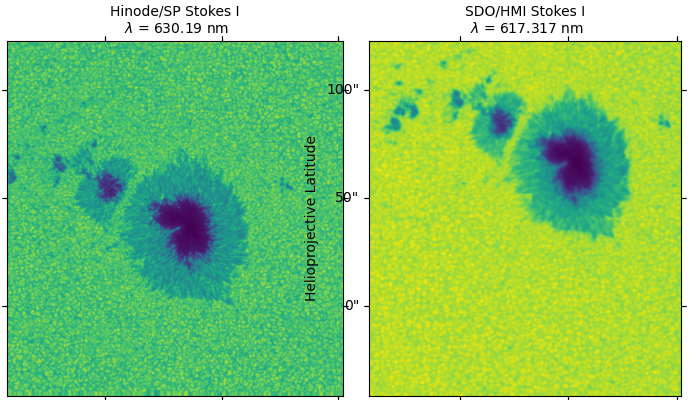

In [82]:
%matplotlib widget

fig = plt.figure(constrained_layout=True, figsize=(7,4), dpi=100)

ax1 = fig.add_subplot(121, projection=SP_map.wcs)
ax2 = fig.add_subplot(122, projection=HMI_map_crop.wcs)

SP_map.plot(ax=ax1)
HMI_map_crop.plot(ax=ax2)

## Calculate the translation offsets between the two images.

To determine the offset between the Hinode and HMI images we need to run a cross-correration.\
To do this we need to crop the HMI image to include the Hinode area together with a border.

In [83]:
pad = 30*u.arcsec

bottom_left_skyc_pad = SkyCoord(Tx = xmin_SP-pad, Ty = ymin_SP-pad, frame = lvl1_c_HMI.meta['frame'])
top_right_skyc_pad = SkyCoord(Tx = xmax_SP+pad, Ty = ymax_SP+pad, frame = lvl1_c_HMI.meta['frame'])

HMI_map_crop_pad = HMI_map.crop((bottom_left_skyc_pad), (top_right_skyc_pad))
print(HMI_map_crop_pad.data.shape)

(444, 406)


### Change Hinode map resolution to match HMI

The Hinode/SP map has a different spatial resolution so we first match resolutions
by degrading the higher resolution Hinode data to roughy match HMI resolution.

In [84]:
SP_img0 = ndimage.gaussian_filter(SP_map.data,1.3)
SP_img = ndimage.zoom(SP_img0, [HMI_map_crop.data.shape[0]/SP_img0.shape[0], 
                                HMI_map_crop.data.shape[1]/SP_img0.shape[1]])

print('Zoom values: ', HMI_map_crop.data.shape[0]/SP_img0.shape[0],
                         HMI_map_crop.data.shape[1]/SP_img0.shape[1])

print('Original image shape: ', SP_img0.shape)
print('Degraded resolution image shape: ', SP_img.shape)
print('HMI cutout image shape: ', HMI_map_crop.data.shape)

Zoom values:  0.634765625 0.5896907216494846
Original image shape:  (512, 485)
Degraded resolution image shape:  (325, 286)
HMI cutout image shape:  (325, 286)


We can overplot the HMI and resized Hinode map.\
This makes it easier to see the offset images.

Text(0, 0.5, 'Pixel')

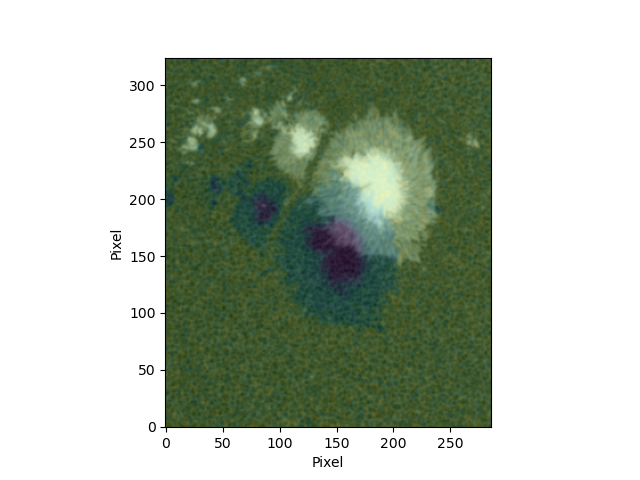

In [86]:
%matplotlib widget

ax1 = plt.subplot(111)

ax1.imshow(SP_img, origin='lower')
ax1.imshow(HMI_map_crop.data, origin='lower', cmap='Greys', alpha=0.7)

ax1.set_xlabel('Pixel')
ax1.set_ylabel('Pixel')

### Calculate the alignment offset

The co-alignment is calculated between the padded cropped HMI image and the resampled
Hinode map. \
The padding around the HMI cropped area also needs to be removed to calculate
the final shift.

We can use the pixel plate scale from each instrument to calculate the offsets between the
images in world coordinates and pixel units. 

In [87]:
xyshift = coalignment.calculate_shift(HMI_map_crop_pad.data, SP_img)

HMI_cdelt = lvl1_c_HMI.wcs.wcs.cdelt[0:2] * u.Quantity(1, lvl1_c_HMI.wcs.world_axis_units[0])/u.pix
SP_cdelt = lvl1_c_SP.wcs.wcs.cdelt[0:2] * u.Quantity(1, lvl1_c_SP.wcs.world_axis_units[0])/u.pix

# Calculate the shifts needed in real world coordinates.
xyshift_real = []
xyshift_real.append(xyshift[0] * HMI_cdelt[0] - pad)
xyshift_real.append(xyshift[1] * HMI_cdelt[1] - pad)

print('HMI (x,y) pixel sampling       = ', HMI_cdelt.to(u.arcsec/u.pix))
print('Hinode/SP (x,y) pixel sampling = ', SP_cdelt.to(u.arcsec/u.pix))


print('Offset along the x direction = ', np.round(xyshift_real[1].to(u.arcsec),1), ' = ', \
                                      np.round(xyshift_real[1]/HMI_cdelt[1],1), '[HMI] =', \
                                      np.round(xyshift_real[1]/SP_cdelt[1],1), '[SP]')
print('Offset along the y direction = ', np.round(xyshift_real[0].to(u.arcsec),1), ' = ',\
                                      np.round(xyshift_real[0]/HMI_cdelt[0]), '[HMI] =',
                                      np.round(xyshift_real[0]/SP_cdelt[0],1), '[SP]')

HMI (x,y) pixel sampling       =  [0.50434315 0.50434315] arcsec / pix
Hinode/SP (x,y) pixel sampling =  [0.29714 0.31998] arcsec / pix
Offset along the x direction =  17.6 arcsec  =  34.9 pix [HMI] = 55.0 pix [SP]
Offset along the y direction =  30.0 arcsec  =  60.0 pix [HMI] = 101.0 pix [SP]


### Recrop the HMI data to see if the alignment is improved.

In [88]:
bottom_left_skyc_1 = SkyCoord(Tx = xmin_SP+xyshift_real[1], Ty = ymin_SP+xyshift_real[0], frame = lvl1_c_HMI.meta['frame'])
top_right_skyc_1 = SkyCoord(Tx = xmax_SP+xyshift_real[1], Ty = ymax_SP+xyshift_real[0], frame = lvl1_c_HMI.meta['frame'])

HMI_map_crop_1 = HMI_map.crop((bottom_left_skyc_1), (top_right_skyc_1))
print(HMI_map_crop_1.data.shape)

(325, 286)


We can overplot the HMI and resized Hinode map after the shift correction. \
We notice that the two image fit very well.

Text(0, 0.5, 'Pixel')

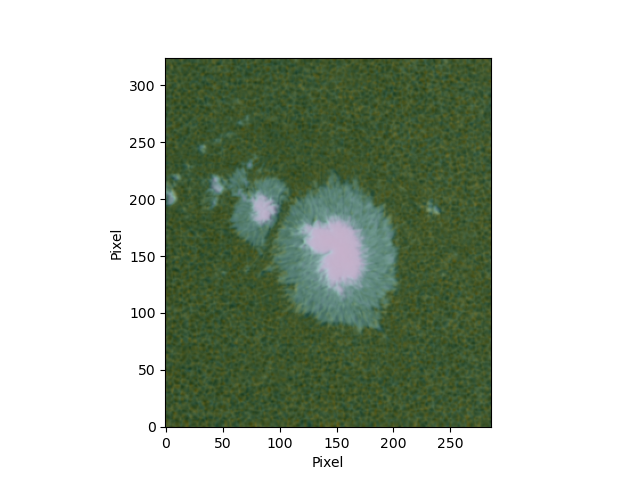

In [90]:
%matplotlib widget

ax1 = plt.subplot(111)

ax1.imshow(SP_img, origin='lower')
ax1.imshow(HMI_map_crop_1.data, origin='lower', cmap='Greys', alpha=0.7)

ax1.set_xlabel('Pixel')
ax1.set_ylabel('Pixel')

Comparing the data arrays using the WCS units we see that there is still a mismatch between
the physical coordinates for the two regions. \
This can be fixed by correcting the WCS attached to one of the StokesCube objects.

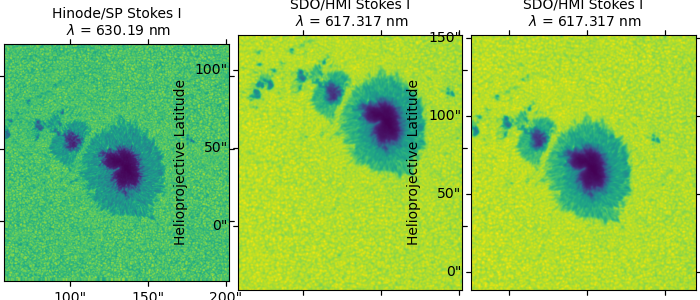

In [91]:
%matplotlib widget

fig = plt.figure(constrained_layout=True, figsize=(7,3), dpi=100)

ax1 = fig.add_subplot(131, projection=SP_map.wcs)
ax2 = fig.add_subplot(132, projection=HMI_map_crop.wcs)
ax3 = fig.add_subplot(133, projection=HMI_map_crop_1.wcs)

SP_map.plot(ax=ax1)
HMI_map_crop.plot(ax=ax2)
HMI_map_crop_1.plot(ax=ax3)

## Change the Hinode/SP WCS to correct for the offset

There are two ways to perform a translation of the WCS: 

1. Modify the crval values that save the center location in the real world system (e.g. Helioprojective)\
To implement this we convert the offsets from HMI pixels to offsets in real world coordinates.

2. Modify the crpix value that save the center location in pixel units.\
The Hinode/SP plate scale is different from SDO/HMI and the cross-correlation is computed in HMI pixels.\
To implement this we have to perform an extra step of converting from real world coordinates into SP pixels.

Here we demonstrate the first solution.

In [92]:
target_wcs = lvl1_c_SP.wcs.deepcopy()
target_wcs.wcs.crval[0] += xyshift_real[1].value
target_wcs.wcs.crval[1] += xyshift_real[0].value

lvl1_c_SP_1 = stokespy.StokesCube(lvl1_c_SP.data, target_wcs)
lvl2_c_SP_1 = stokespy.MagVectorCube(lvl2_c_SP.data, target_wcs, magnetic_params=lvl2_c_SP.magnetic_axis)

lvl1_c_SP.wcs, lvl1_c_SP_1.wcs

(WCS Keywords
 
 Number of WCS axes: 4
 CTYPE : 'HPLN-TAN'  'HPLT-TAN'  'WAVE'  'STOKES'  
 CRVAL : 0.03610083333333333  0.011277222222222221  6.30208e-07  0.0  
 CRPIX : 243.0  256.5  56.5  0.0  
 PC1_1 PC1_2 PC1_3 PC1_4  : 1.0  0.0  0.0  0.0  
 PC2_1 PC2_2 PC2_3 PC2_4  : 0.0  1.0  0.0  0.0  
 PC3_1 PC3_2 PC3_3 PC3_4  : 0.0  0.0  1.0  0.0  
 PC4_1 PC4_2 PC4_3 PC4_4  : 0.0  0.0  0.0  1.0  
 CDELT : 8.253888951416667e-05  8.888333208027778e-05  2.1549e-12  1.0  
 NAXIS : 0  0,
 WCS Keywords
 
 Number of WCS axes: 4
 CTYPE : 'HPLN-TAN'  'HPLT-TAN'  'WAVE'  'STOKES'  
 CRVAL : 0.04099321286583741  0.019615231970415658  6.30208e-07  0.0  
 CRPIX : 243.0  256.5  56.5  0.0  
 PC1_1 PC1_2 PC1_3 PC1_4  : 1.0  0.0  0.0  0.0  
 PC2_1 PC2_2 PC2_3 PC2_4  : 0.0  1.0  0.0  0.0  
 PC3_1 PC3_2 PC3_3 PC3_4  : 0.0  0.0  1.0  0.0  
 PC4_1 PC4_2 PC4_3 PC4_4  : 0.0  0.0  0.0  1.0  
 CDELT : 8.253888951416667e-05  8.888333208027778e-05  2.1549e-12  1.0  
 NAXIS : 0  0)

Define a new image from the updated cube.

In [93]:
SP_map_1 = lvl1_c_SP_1.I_map(wav_SP)

ix_0, wav0 =  47 6.3018968335e-07 m


Recrop the HMI data to the updated Hinode image coordinates.

In [95]:
xmin_SP_1, xmax_SP_1 = lvl1_c_SP_1.coord2_axis(0)[0].Tx, lvl1_c_SP_1.coord2_axis(0)[-1].Tx
ymin_SP_1, ymax_SP_1 = lvl1_c_SP_1.coord1_axis(0)[0].Ty, lvl1_c_SP_1.coord1_axis(0)[-1].Ty

bottom_left_skyc_1 = SkyCoord(Tx = xmin_SP_1, Ty = ymin_SP_1, frame = lvl1_c_HMI.meta['frame'])
top_right_skyc_1 = SkyCoord(Tx = xmax_SP_1, Ty = ymax_SP_1, frame = lvl1_c_HMI.meta['frame'])

HMI_map_crop_1 = HMI_map.crop((bottom_left_skyc_1), (top_right_skyc_1))
print(HMI_map_crop_1.data.shape)

(325, 286)


Compare the results of the alignment.
Visually it seems like the two images are aligned and mapped to the same physical coordinates.

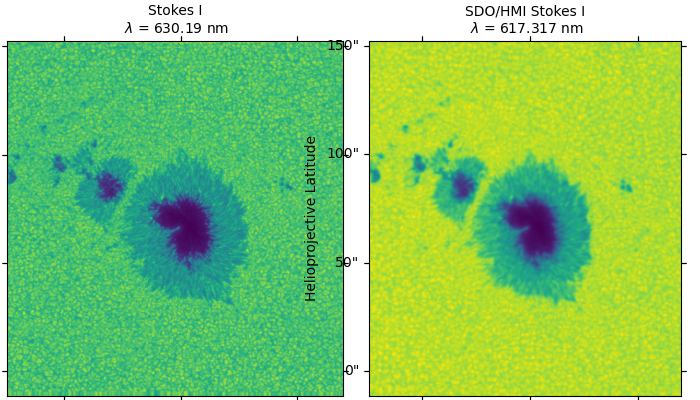

In [98]:
%matplotlib widget

fig = plt.figure(constrained_layout=True, figsize=(7,4), dpi=100)

ax1 = fig.add_subplot(121, projection=SP_map_1.wcs)
ax2 = fig.add_subplot(122, projection=HMI_map_crop_1.wcs)

SP_map_1.plot(ax=ax1)
HMI_map_crop_1.plot(ax=ax2)

## Look at spectra from both sets of data

Choose a point in the image to look at the data.

In [99]:
test_skyc = SkyCoord(Tx = 148 * u.arcsec, Ty = 67 * u.arcsec, \
                               frame = lvl1_c_HMI.meta['frame'])

By passing the desired coordinate via the coords keyword we can visualize all the Stokes spectra along with a slider enabled view of the full image.

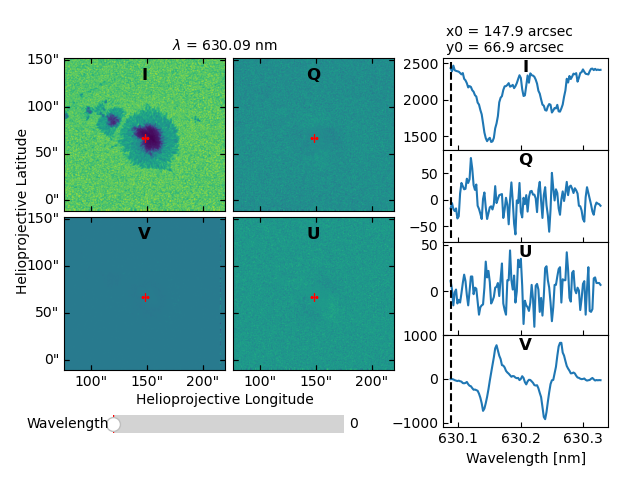

In [100]:
%matplotlib widget

lvl1_c_SP_1.plot(coords=test_skyc)

Adding the context keyword and passing either 'I', 'Q', 'U', 'V' we can display different context imformation for the pixel.

243 244


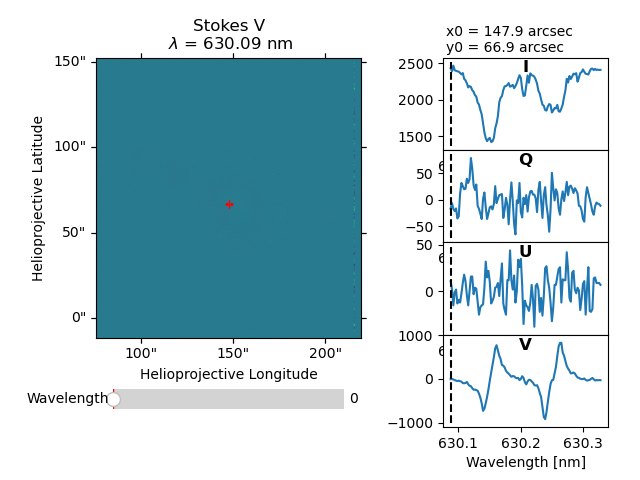

In [101]:
%matplotlib widget

lvl1_c_SP_1.plot(coords=test_skyc, context='V')

To make it easier to visualize we can crop the larger HMI StokesCube to the Hinode FOV.\

In [102]:
HMI_cube_crop_1 = lvl1_c_HMI.crop((bottom_left_skyc_1, None, None), (top_right_skyc_1, None, None))
print(HMI_cube_crop_1.data.shape)

(4, 6, 325, 286)


143 155


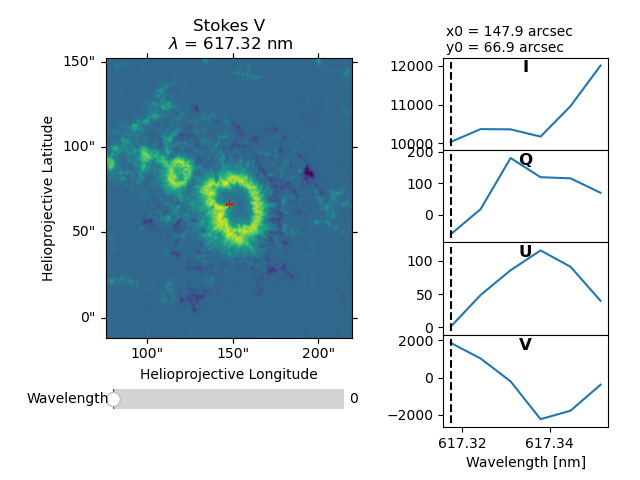

In [103]:
%matplotlib widget

HMI_cube_crop_1.plot(coords=test_skyc, context='V')